In [46]:
import pandas as pd
import numpy as np
import os, math, time
from collections import Counter
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import roc_auc_score
from scipy.stats import beta, gamma

# References
This code is based on Python, a general KDE and Gamma KDE introduced in the paper below.

[Probability Density Function Estimation Using Gamma Kernels](https://link.springer.com/article/10.1023/A:1004165218295)

#### toy example

In [28]:
# Gaussian kde
def gaussian_kernel(x,mean,std):
    K = (1 / (np.sqrt(2 * np.pi)*std)) * np.exp(- (x-mean) ** 2 / (2*std**2))
    return K

def optimal_bwd(x):
    bwd = 1.06*len(x)**(-0.2)*np.std(x)
    return bwd

def apply_kernel(data, x, bwd):
    y = 0
    for x_i in data:
        y += gaussian_kernel((x-x_i)/bwd,0,1)
    kde = y/(len(data)*bwd) 
    return kde

def gaussian_kde(x0,data,col):
    n = len(data)
    if len([col]) > 1:
        bwidth = data[col].apply(lambda x:optimal_bwd(x))
        kde = {}
        for x_col in range(len(col)):
            prob = apply_kernel(data.iloc[:,x_col], x0.iloc[:,x_col], bwidth[x_col])
            kde[x_col] = prob
        est = pd.DataFrame(kde)
    else:
        bwidth = optimal_bwd(data[col])
        est = apply_kernel(data[col], x0, bwidth)  
    return est

In [64]:
# true distribution
X = np.arange(-8,8,0.01)
Y_1 = stats.norm.pdf(X, loc=4.0, scale=2.0)
Y_2 = stats.norm.pdf(X, loc=-1.0, scale=1.0)
Y = 0.5*(Y_1+Y_2)

# kde
seq = np.arange(-8,8,0.01)
data_1 = np.random.normal(loc=4.0, scale=2.0, size=100) 
data_2 = np.random.normal(loc=-1.0, scale=1.0, size=100)
data = np.concatenate([data_1,data_2], axis=0) 
dens = gaussian_kde(seq,pd.DataFrame(data,columns=["X"]),"X")
estimator = stats.gaussian_kde(data, bw_method='silverman')
K = estimator(X)

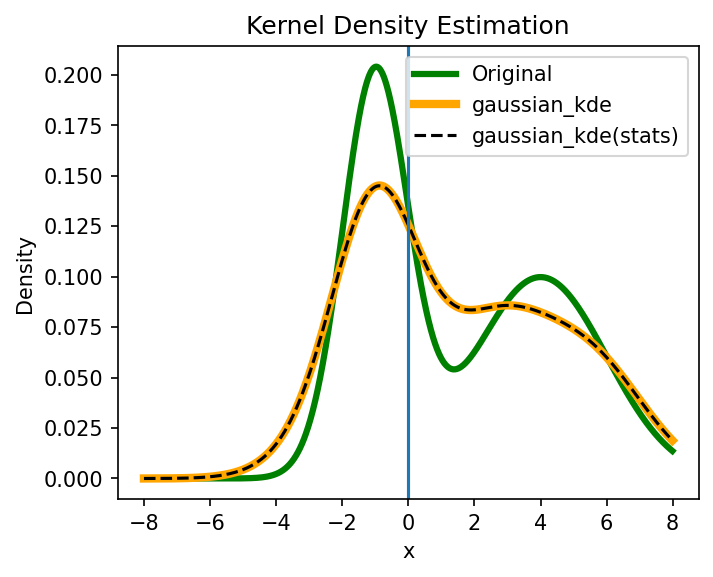

true pdf on x=0: 0.134
KDE_ pdf on x=0: 0.126


In [67]:
fig, ax = plt.subplots(figsize=(5,4), dpi=150)
plt.plot(seq,Y, linewidth=3, color="green", label='Original')
plt.plot(seq, dens, linewidth=4, color="orange", label='gaussian_kde')
plt.plot(seq, K, linewidth=1.5, linestyle="--", color="black", label='gaussian_kde(stats)')
plt.legend(loc='best')
plt.axvline(x=0)
plt.xlabel("x")
plt.ylabel('Density')
plt.title("Kernel Density Estimation")
plt.show()
print(f"true pdf on x=0: {round(Y[800],3)}")
print(f"KDE_ pdf on x=0: {round(dens[800],3)}")

# Boundary Bias

## Fixed symmetric kernel
Gaussian kernel

In [5]:
# true distribution
X = np.arange(0,1,0.001)
a = 1
b = 4
Y = beta(a, b).pdf(X) 

# kde
seq = np.arange(-0.5,1,0.001)
np.random.seed(2021)
data = pd.DataFrame(np.random.beta(a,b,size=1000),columns=["X"])
dens = gaussian_kde(seq,data,"X")
estimator = stats.gaussian_kde(np.array(data["X"]), bw_method='silverman')
K = estimator(seq)

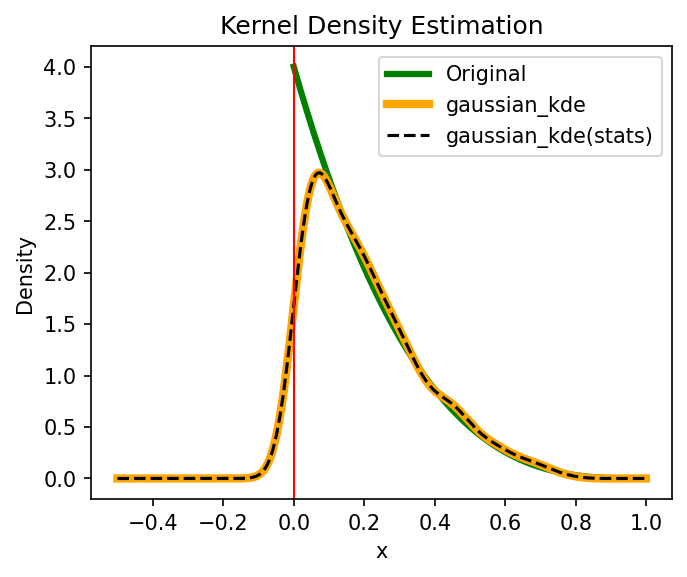

true pdf on x=0: 4.0
KDE_ pdf on x=0: 1.672


In [6]:
fig, ax = plt.subplots(figsize=(5,4), dpi=150)
plt.plot(X, Y, linewidth=3, color="green", label='Original')
plt.plot(seq, dens, linewidth=4, color="orange", label='gaussian_kde')
plt.plot(seq, K, linewidth=1.5, linestyle="--", color="black", label='gaussian_kde(stats)')
plt.axvline(x=0, linewidth=1, color="red")
plt.legend(loc='best')
plt.xlabel("x")
plt.ylabel('Density')
plt.title("Kernel Density Estimation")
plt.show()
print(f"true pdf on x=0: {Y[0]}")
print(f"KDE_ pdf on x=0: {round(dens[500],3)}")

## flexible kernel
Gamma kernel

In [7]:
# Gamma kde
def gamma_kernel(x, alpha, beta):
    K = (math.gamma(alpha)*(beta**alpha))**(-1)*x**(alpha-1)*np.exp(-x/beta)
    return K

def optimal_bwd(x):
    bwd = 1.06*len(x)**(-0.2)*np.std(x)
    return bwd

def apply_kernel(data, x, bwd):
    y = 0
    for x_i in data:
        y += gamma_kernel(x_i,x/bwd+1,bwd)
    kde = y/len(data) 
    return kde

def apply_kernel2(data, x, bwd):
    y = 0
    for x_i in data:
        if x >= 2*bwd:
            y += gamma_kernel(x_i,x/bwd,bwd)
        else:
            y += gamma_kernel(x_i,0.25*(x/bwd)**2+1,bwd)
        kde = y/len(data) 
    return kde

def gamma_kde(x0,data,col,bwidth,opt):
    n = len(data)
    if len([col]) > 1:
#         bwidth = data[col].apply(lambda x:optimal_bwd(x))
        kde = {}
        for x_col in range(len(col)):
            prob = apply_kernel(data.iloc[:,x_col], x0.iloc[:,x_col], bwidth[x_col])
            kde[x_col] = prob
        est = pd.DataFrame(kde)
    else:
#         bwidth = optimal_bwd(data[col])
        if opt == "f1":
            est = np.array(list(map(lambda x0_i: apply_kernel(data[col], x0_i, bwidth), x0))) 
        elif opt == "f2":
            est = np.array(list(map(lambda x0_i: apply_kernel2(data[col], x0_i, bwidth), x0)))
    return est


In [8]:
# kde
bwd1 = bwd2 = optimal_bwd(data["X"]) # 0.043078
seq = np.arange(-0.5,1,0.001)
np.random.seed(2021)
data = pd.DataFrame(np.random.beta(a,b,size=1000),columns=["X"])
dens = gamma_kde(X,data,"X",bwd1,"f1")
dens2 = gamma_kde(X,data,"X",bwd2,"f2")
estimator = stats.gaussian_kde(np.array(data["X"]), bw_method='silverman')
K = estimator(seq)

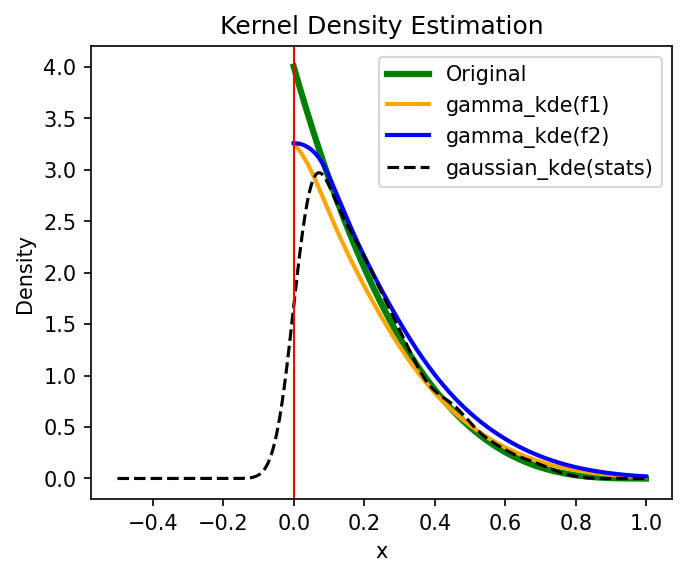

true pdf on x=0: 4.0
KDE1 pdf on x=0: 3.257
KDE2 pdf on x=0: 3.257


In [9]:
fig, ax = plt.subplots(figsize=(5,4), dpi=150)
plt.plot(X, Y, linewidth=3, color="green", label='Original')
plt.plot(X, dens, linewidth=2, color="orange", label='gamma_kde(f1)')
plt.plot(X, dens2, linewidth=2, color="blue", label='gamma_kde(f2)')
plt.plot(seq, K, linewidth=1.5, linestyle="--", color="black", label='gaussian_kde(stats)')
plt.axvline(x=0, linewidth=1, color="red")
plt.legend(loc='best')
plt.xlabel("x")
plt.ylabel('Density')
plt.title("Kernel Density Estimation")
plt.show()
print(f"true pdf on x=0: {Y[0]}")
print(f"KDE1 pdf on x=0: {round(dens[0],3)}")
print(f"KDE2 pdf on x=0: {round(dens2[0],3)}")

In [10]:
# change bwd
bwd1_1 = bwd2_1 = 0.01
dens_1 = gamma_kde(X,data,"X",bwd1_1,"f1")
dens2_1 = gamma_kde(X,data,"X",bwd2_1,"f2")

bwd1_2 = bwd2_2 = 0.1
dens_2 = gamma_kde(X,data,"X",bwd1_2,"f1")
dens2_2 = gamma_kde(X,data,"X",bwd2_2,"f2")

bwd1_3 = bwd2_3 = 0.007
dens_3 = gamma_kde(X,data,"X",bwd1_3,"f1")
dens2_3 = gamma_kde(X,data,"X",bwd2_3,"f2")

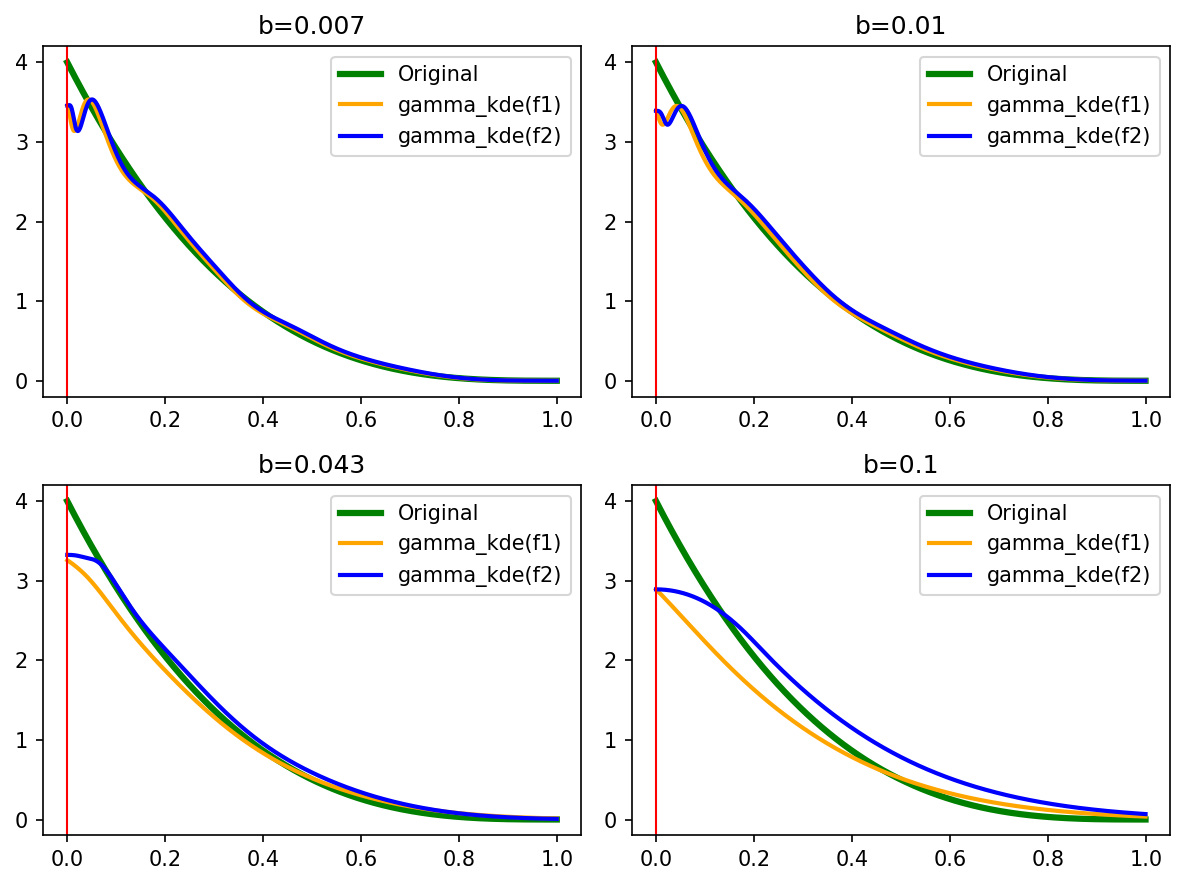

In [19]:
# kde
fig, ax = plt.subplots(figsize=(8,6), ncols=2, nrows=2, dpi=150)
def plot(ax, dens, dens2, bwd):
    ax.plot(X, Y, linewidth=3, color="green", label='Original')
    ax.plot(X, dens, linewidth=2, color="orange", label='gamma_kde(f1)')
    ax.plot(X, dens2, linewidth=2, color="blue", label='gamma_kde(f2)')
#     ax.plot(seq, K, linewidth=1.5, linestyle="--", color="black", label='gaussian_kde(stats)')
    ax.axvline(x=0, linewidth=1, color="red")
    ax.legend(loc='best')
    ax.set_title(f"b={bwd}")
plot(ax[0,0], dens_3, dens2_3, bwd1_3)
plot(ax[0,1], dens_1, dens2_1, bwd1_1)
plot(ax[1,0], dens, dens2, round(bwd1, 3))
plot(ax[1,1], dens_2, dens2_2, bwd1_2)
plt.tight_layout()

In [20]:
# change bwd
bwd1 = optimal_bwd(data["X"])
bwd2 = 0.02
seq = np.arange(-0.5,1,0.001)
np.random.seed(2021)
data = pd.DataFrame(np.random.beta(a,b,size=1000),columns=["X"])
dens = gamma_kde(X,data,"X",bwd1,"f1")
dens2 = gamma_kde(X,data,"X",bwd2,"f2")
estimator = stats.gaussian_kde(np.array(data["X"]), bw_method='silverman')
K = estimator(seq)

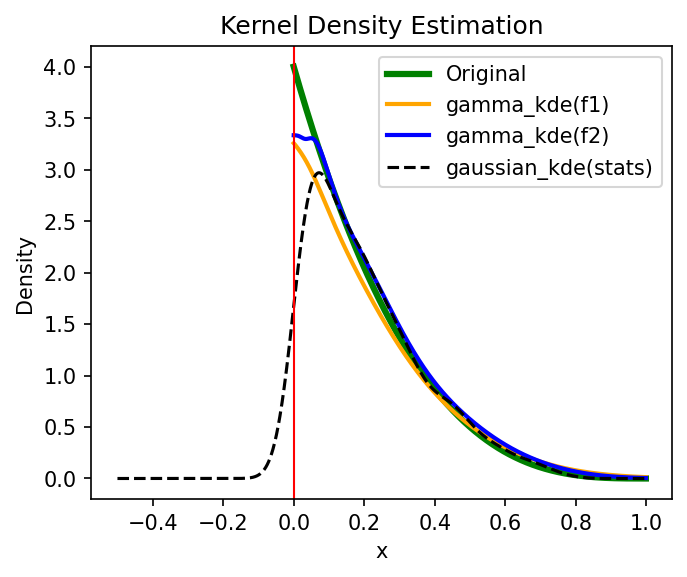

true pdf on x=0: 4.0
KDE1 pdf on x=0: 3.257
KDE2 pdf on x=0: 3.334


In [21]:
fig, ax = plt.subplots(figsize=(5,4), dpi=150)
plt.plot(X, Y, linewidth=3, color="green", label='Original')
plt.plot(X, dens, linewidth=2, color="orange", label='gamma_kde(f1)')
plt.plot(X, dens2, linewidth=2, color="blue", label='gamma_kde(f2)')
plt.plot(seq, K, linewidth=1.5, linestyle="--", color="black", label='gaussian_kde(stats)')
plt.axvline(x=0, linewidth=1, color="red")
plt.legend(loc='best')
plt.xlabel("x")
plt.ylabel('Density')
plt.title("Kernel Density Estimation")
plt.show()
print(f"true pdf on x=0: {Y[0]}")
print(f"KDE1 pdf on x=0: {round(dens[0],3)}")
print(f"KDE2 pdf on x=0: {round(dens2[0],3)}")

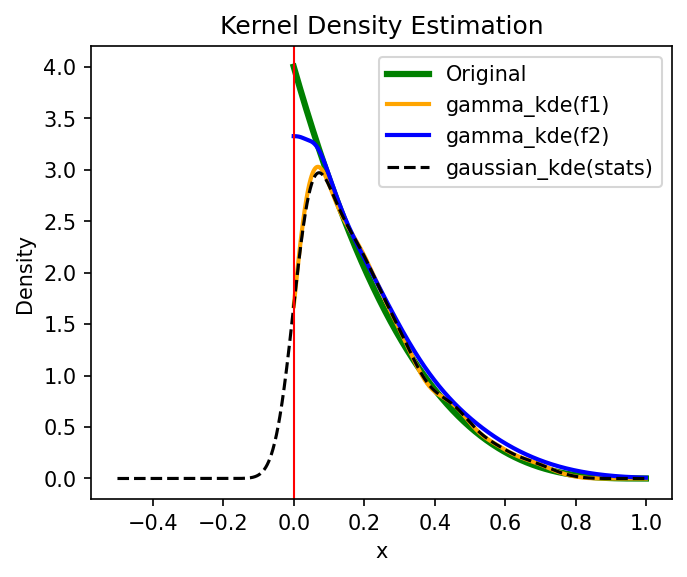

true pdf on x=0: 4.0
KDE1 pdf on x=0: 1.674
KDE2 pdf on x=0: 3.325


In [47]:
fig, ax = plt.subplots(figsize=(5,4), dpi=150)
plt.plot(X, Y, linewidth=3, color="green", label='Original')
plt.plot(X, dens, linewidth=2, color="orange", label='gamma_kde(f1)')
plt.plot(X, dens2, linewidth=2, color="blue", label='gamma_kde(f2)')
plt.plot(seq, K, linewidth=1.5, linestyle="--", color="black", label='gaussian_kde(stats)')
plt.axvline(x=0, linewidth=1, color="red")
plt.legend(loc='best')
plt.xlabel("x")
plt.ylabel('Density')
plt.title("Kernel Density Estimation")
plt.show()
print(f"true pdf on x=0: {Y[0]}")
print(f"KDE1 pdf on x=0: {round(dens[0],3)}")
print(f"KDE2 pdf on x=0: {round(dens2[0],3)}")